In [39]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [40]:
df = yf.Ticker("MSFT").history(period="5d")
print(df.tail())


                                 Open        High         Low       Close  \
Date                                                                        
2025-06-20 00:00:00-04:00  482.230011  483.459991  476.869995  477.399994   
2025-06-23 00:00:00-04:00  478.209991  487.750000  472.510010  486.000000   
2025-06-24 00:00:00-04:00  488.950012  491.850006  486.799988  490.109985   
2025-06-25 00:00:00-04:00  492.040009  494.559998  489.390015  492.269989   
2025-06-26 00:00:00-04:00  492.980011  496.959991  492.929993  493.720001   

                             Volume  Dividends  Stock Splits  
Date                                                          
2025-06-20 00:00:00-04:00  37576200        0.0           0.0  
2025-06-23 00:00:00-04:00  24864000        0.0           0.0  
2025-06-24 00:00:00-04:00  22305600        0.0           0.0  
2025-06-25 00:00:00-04:00  17475600        0.0           0.0  
2025-06-26 00:00:00-04:00   4514677        0.0           0.0  


In [41]:
ticker = "MSFT"
period = "1y"
df = yf.download(ticker, period=period, interval="1d", auto_adjust=True)

[*********************100%***********************]  1 of 1 completed


In [42]:

def preprocess_stock_data(ticker="AAPL", period="1y"):
    df = yf.download(ticker, period=period, interval="1d", auto_adjust=True)
    df["Close_lag1"] = df["Close"].shift(1)
    df["Volume_lag1"] = df["Volume"].shift(1)
    df["Close_rolling_mean_3"] = df["Close"].rolling(3).mean()
    df["Close_rolling_std_3"] = df["Close"].rolling(3).std()
    df["target"] = df["Close"].shift(-1)
    df.dropna(inplace=True)

    features = ["Open", "High", "Low", "Volume", "Close_lag1", "Volume_lag1", "Close_rolling_mean_3", "Close_rolling_std_3"]
    X = df[features].values
    y = df["target"].values.reshape(-1, 1)

    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y)

    return X_scaled, y_scaled, scaler_y


In [43]:
import time
import psutil
import os
import sys
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(y_true, y_pred, model_obj, model_name, start_time, end_time):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Số lượng tham số (nếu là model Keras)
    try:
        params = model_obj.count_params()
    except:
        params = "N/A"

    # Dung lượng RAM sử dụng
    ram_used = psutil.Process(os.getpid()).memory_info().rss / (1024 ** 2)  # in MB

    # Kích thước mô hình (ước lượng)
    try:
        model_size = sys.getsizeof(model_obj)
    except:
        model_size = "N/A"

    return {
        "model": model_name,
        "mse": mse,
        "mae": mae,
        "r2": r2 * 100,
        "time": end_time - start_time,
        "params": params,
        "model_size": model_size,
        "ram_usage": ram_used,
        "y_pred": y_pred
    }


In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time

def run_lstm(X_scaled, y_scaled, scaler_y):
    X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(X_lstm.shape[1], X_lstm.shape[2])),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

    start = time.time()
    history = model.fit(X_lstm, y_scaled, epochs=30, batch_size=16, verbose=0)
    end = time.time()

    y_pred = scaler_y.inverse_transform(model.predict(X_lstm))
    y_true = scaler_y.inverse_transform(y_scaled)

    return {
        "model": "LSTM",
        "mse": mean_squared_error(y_true, y_pred),
        "mae": mean_absolute_error(y_true, y_pred),
        "r2": r2_score(y_true, y_pred),
        "time": end - start,
        "loss_history": history.history['loss'],
        "y_pred": y_pred 
    }


In [45]:
from tensorflow.keras.layers import GRU

def run_gru(X_scaled, y_scaled, scaler_y):
    X_gru = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
    model = Sequential([
        GRU(50, activation='relu', input_shape=(X_gru.shape[1], X_gru.shape[2])),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    start = time.time()
    history = model.fit(X_gru, y_scaled, epochs=30, batch_size=16, verbose=0)
    end = time.time()
    y_pred = scaler_y.inverse_transform(model.predict(X_gru))
    y_true = scaler_y.inverse_transform(y_scaled)
    return {
        "model": "GRU",
        "mse": mean_squared_error(y_true, y_pred),
        "mae": mean_absolute_error(y_true, y_pred),
        "r2": r2_score(y_true, y_pred),
        "time": end - start,
        "loss_history": history.history['loss'],
        "y_pred": y_pred 
    }


In [46]:
from sklearn.linear_model import LinearRegression
def run_linear(X_scaled, y_scaled, scaler_y):
    model = LinearRegression()
    start = time.time()
    model.fit(X_scaled, y_scaled)
    y_pred = scaler_y.inverse_transform(model.predict(X_scaled))
    y_true = scaler_y.inverse_transform(y_scaled)
    end = time.time()

    return {
        "model": "LinearRegression",
        "mse": mean_squared_error(y_true, y_pred),
        "mae": mean_absolute_error(y_true, y_pred),
        "r2": r2_score(y_true, y_pred),
        "time": end - start,
        "y_pred": y_pred 
    }


In [47]:
from sklearn.ensemble import RandomForestRegressor

def run_rf(X_scaled, y_scaled, scaler_y):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    start = time.time()
    model.fit(X_scaled, y_scaled.ravel())
    y_pred = scaler_y.inverse_transform(model.predict(X_scaled).reshape(-1, 1))
    y_true = scaler_y.inverse_transform(y_scaled)
    end = time.time()

    return {
        "model": "RandomForest",
        "mse": mean_squared_error(y_true, y_pred),
        "mae": mean_absolute_error(y_true, y_pred),
        "r2": r2_score(y_true, y_pred),
        "time": end - start,
        "y_pred": y_pred  
    }


In [48]:
X_scaled, y_scaled, scaler_y = preprocess_stock_data("AAPL", "1y")

results = [
    run_lstm(X_scaled, y_scaled, scaler_y),
    run_gru(X_scaled, y_scaled, scaler_y),
    run_linear(X_scaled, y_scaled, scaler_y),
    run_rf(X_scaled, y_scaled, scaler_y)
]
for r in results:
    print(f"🔍 {r['model']} - MSE: {r['mse']:.4f}, MAE: {r['mae']:.4f}, R2: {r['r2']:.4f}, Time: {r['time']:.4f} s")


[*********************100%***********************]  1 of 1 completed
C:\Users\shiro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


C:\Users\shiro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
🔍 LSTM - MSE: 21.8265, MAE: 3.5516, R2: 0.9099, Time: 3.3546 s
🔍 GRU - MSE: 19.9677, MAE: 3.3524, R2: 0.9175, Time: 3.7399 s
🔍 LinearRegression - MSE: 17.4589, MAE: 3.0709, R2: 0.9279, Time: 0.0022 s
🔍 RandomForest - MSE: 3.1619, MAE: 1.3054, R2: 0.9869, Time: 0.2120 s


🔍 Model: LSTM
   MSE: 21.8265
   MAE: 3.5516
   R2 : 0.9099
   Time: 3.3546 seconds
🔍 Model: GRU
   MSE: 19.9677
   MAE: 3.3524
   R2 : 0.9175
   Time: 3.7399 seconds
🔍 Model: LinearRegression
   MSE: 17.4589
   MAE: 3.0709
   R2 : 0.9279
   Time: 0.0022 seconds
🔍 Model: RandomForest
   MSE: 3.1619
   MAE: 1.3054
   R2 : 0.9869
   Time: 0.2120 seconds


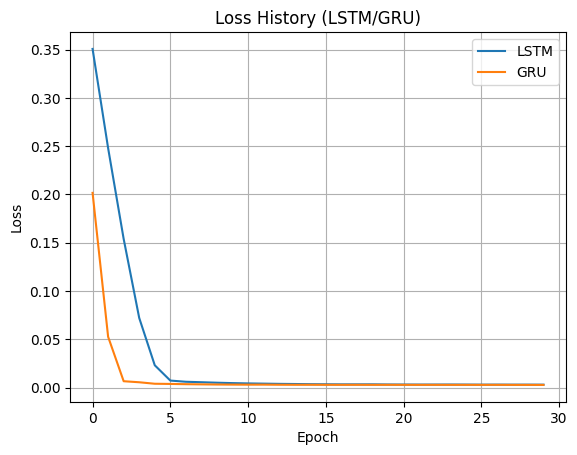

In [49]:

for r in results:
    print(f"🔍 Model: {r['model']}")
    print(f"   MSE: {r['mse']:.4f}")
    print(f"   MAE: {r['mae']:.4f}")
    print(f"   R2 : {r['r2']:.4f}")
    print(f"   Time: {r['time']:.4f} seconds")
    if r.get("loss_history"):
        plt.plot(r["loss_history"], label=r["model"])

plt.title("Loss History (LSTM/GRU)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


C:\Users\shiro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\shiro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


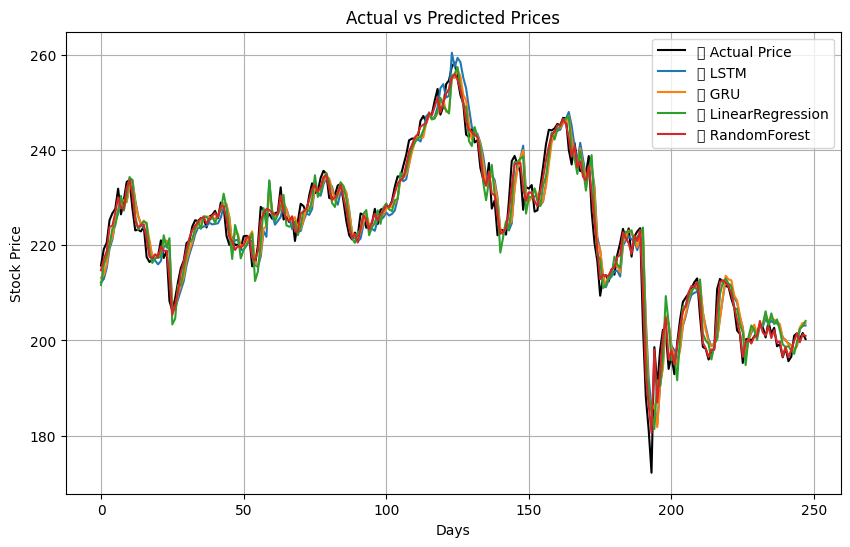

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(scaler_y.inverse_transform(y_scaled), label="🎯 Actual Price", color="black")

for r in results:
    if "y_pred" in r:
        plt.plot(r["y_pred"], label=f"🔮 {r['model']}")

plt.title("Actual vs Predicted Prices")
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()


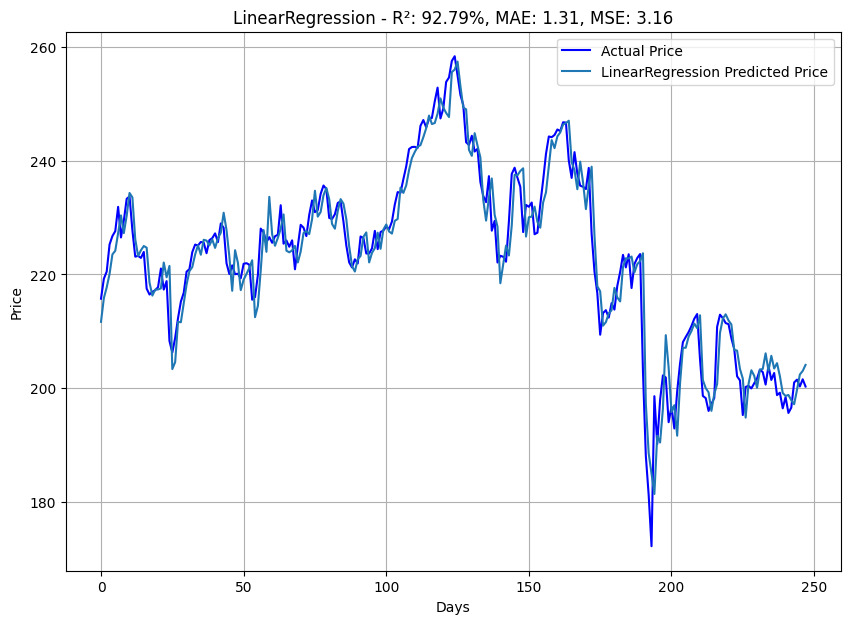

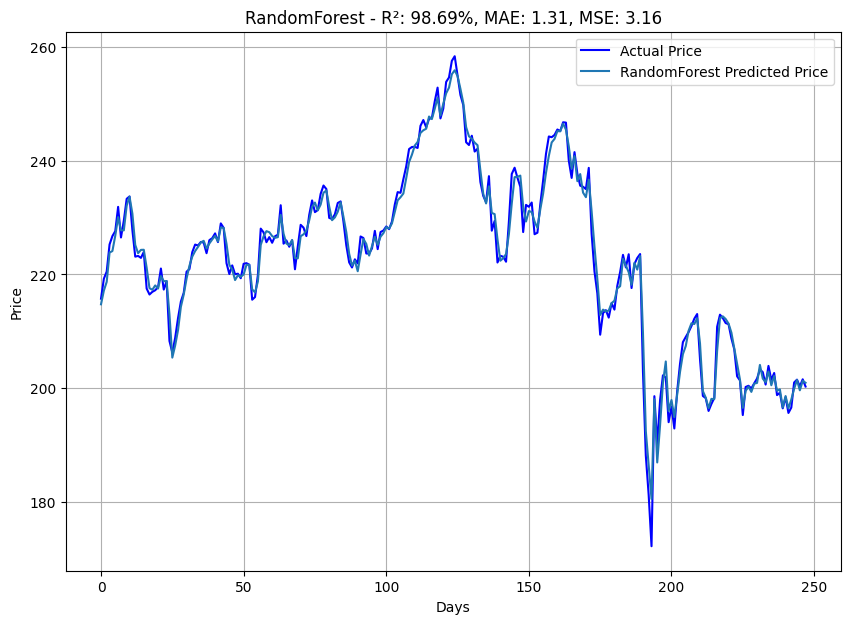

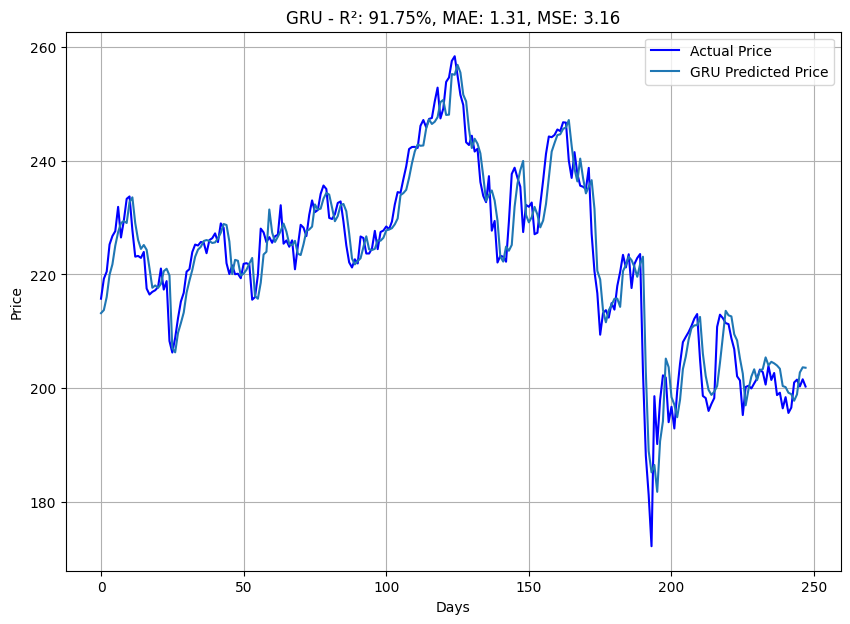

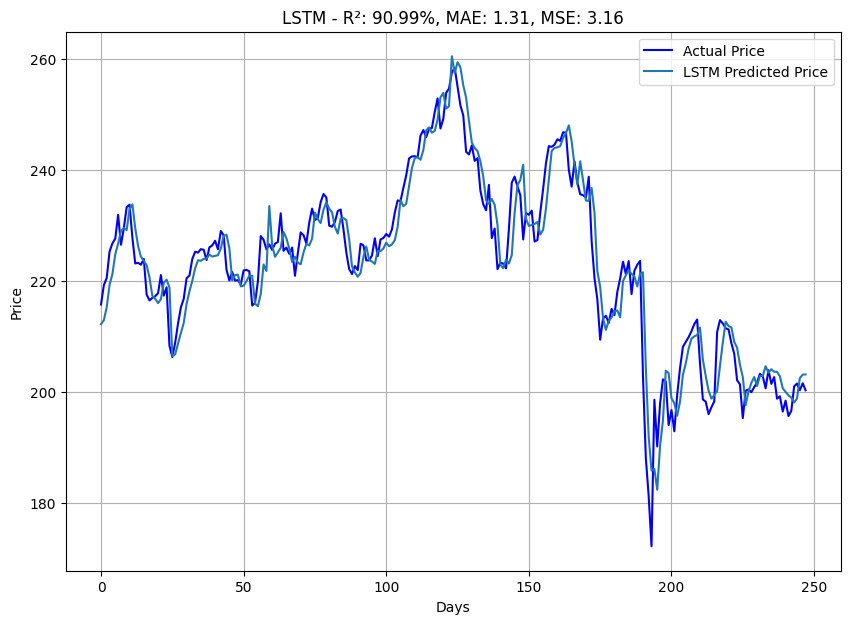

In [52]:
for model_name in ["LinearRegression", "RandomForest", "GRU", "LSTM"]:
    plt.figure(figsize=(10, 7))
    plt.plot(scaler_y.inverse_transform(y_scaled), label='Actual Price', color='blue')

    for r in results:
        if r['model'] == model_name:
            plt.plot(r['y_pred'], label=f"{r['model']} Predicted Price")
            r2_percent = r['r2'] * 100  # Convert R² score to percentage

    plt.title(f"{model_name} - R²: {r2_percent:.2f}%, MAE: {r['mae']:.2f}, MSE: {r['mse']:.2f}")

    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()
